In [79]:
# This notebook partially implements the demo at:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from PIL import Image as pil_Image
from IPython.display import display
from IPython.display import Image as ipy_Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

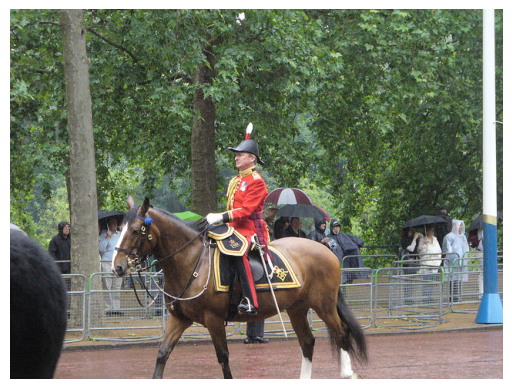

In [80]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)


In [81]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

# Since we are not training, a CUDA gpu is not required
# This config setting required for non-CUDA hardware such as MacOS
cfg.MODEL.DEVICE='cpu'

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

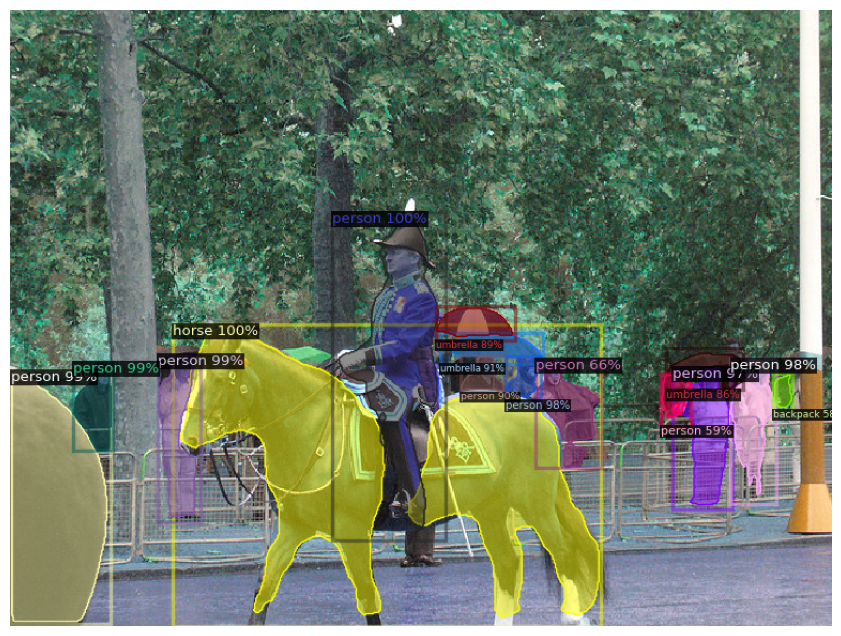

In [82]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

out_image = out.get_image()[:, :, ::-1]

# Display the image using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(out_image)
plt.axis('off')  # Turn off axis numbers
plt.show()


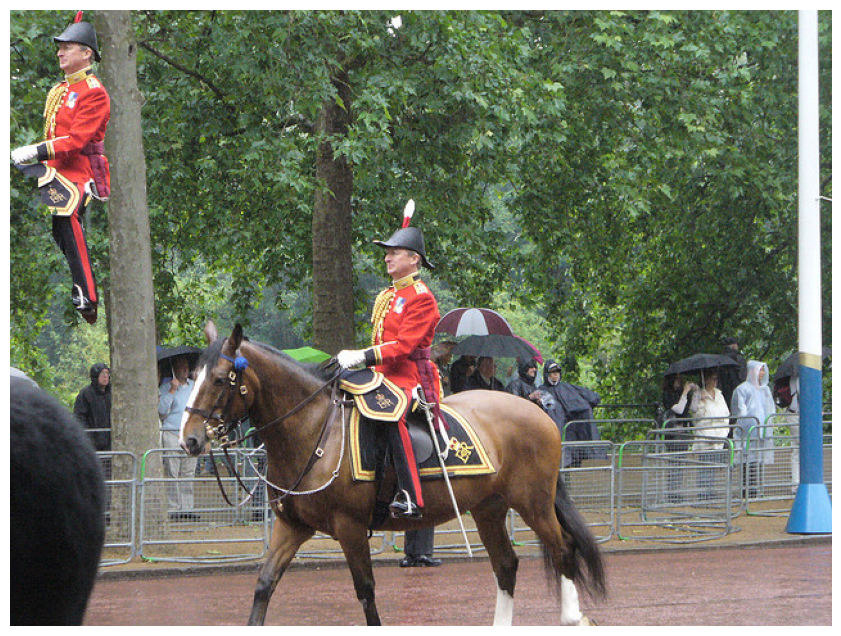

In [83]:
# Example showing how to extract single masked image

masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))
item_mask = masks[1]
segmentation = np.where(item_mask == True)
x_min = int(np.min(segmentation[1]))
x_max = int(np.max(segmentation[1]))
y_min = int(np.min(segmentation[0]))
y_max = int(np.max(segmentation[0]))

cropped = pil_Image.fromarray(im[y_min:y_max, x_min:x_max, :], mode='RGB')
mask = pil_Image.fromarray((item_mask * 255).astype('uint8'))
cropped_mask = mask.crop((x_min, y_min, x_max, y_max))
background = pil_Image.fromarray(im, mode='RGB')

# Put copy of extracted image in the top left corner
paste_position = (0, 0)
new_fg_image = pil_Image.new('RGB', background.size)
new_fg_image.paste(cropped, paste_position)
new_alpha_mask = pil_Image.new('L', background.size, color = 0)
new_alpha_mask.paste(cropped_mask, paste_position)

composite = pil_Image.composite(new_fg_image, background, new_alpha_mask)

out_image = np.array(composite)

img = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

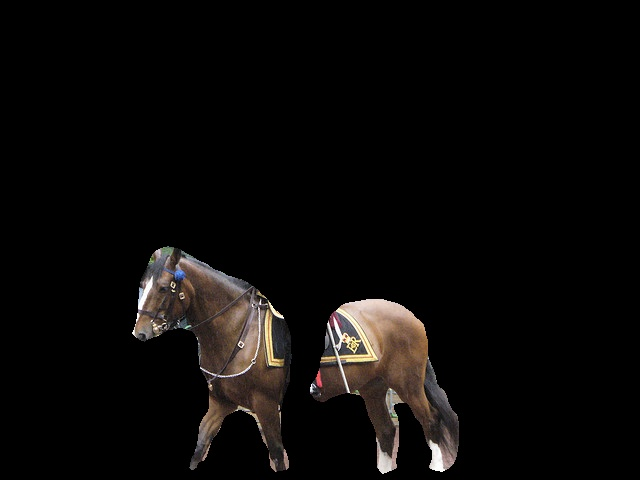

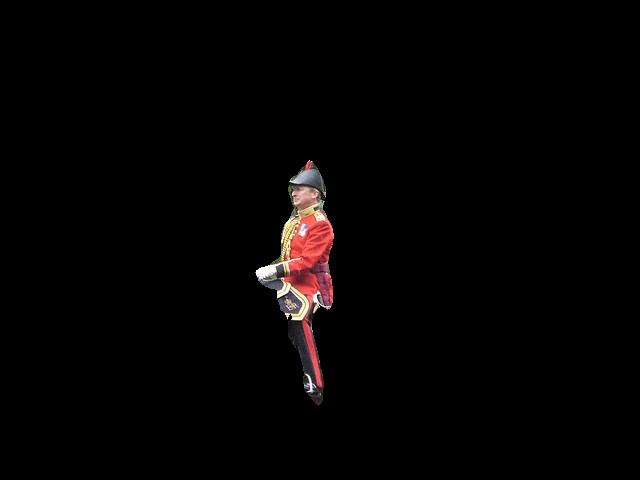

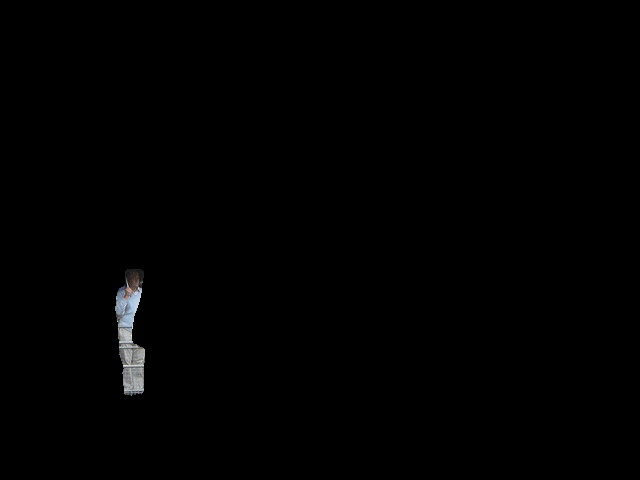

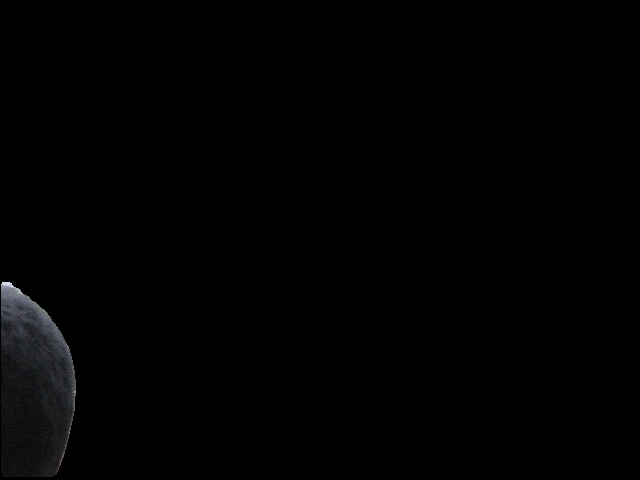

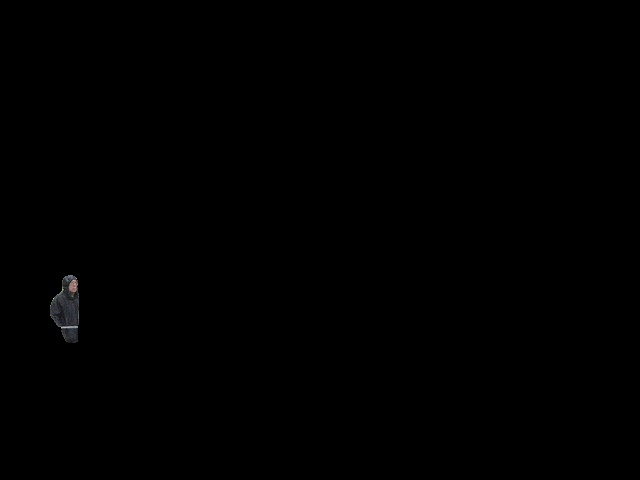

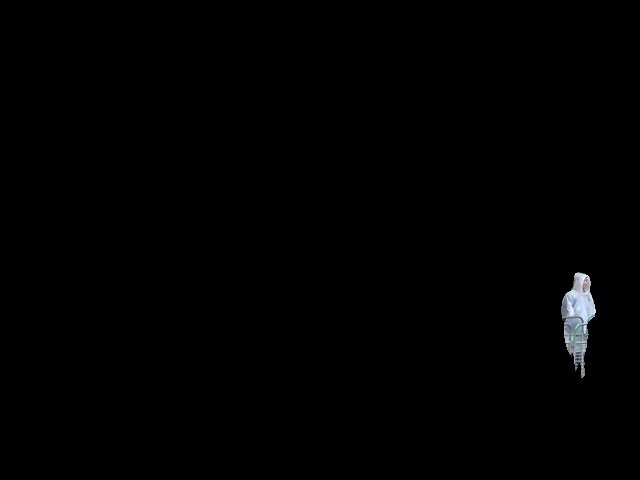

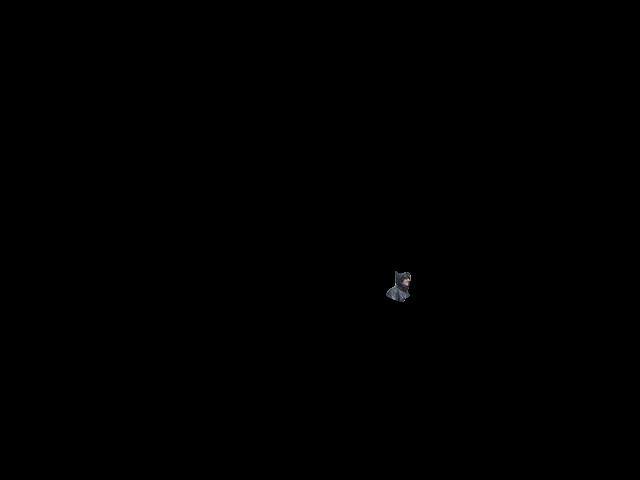

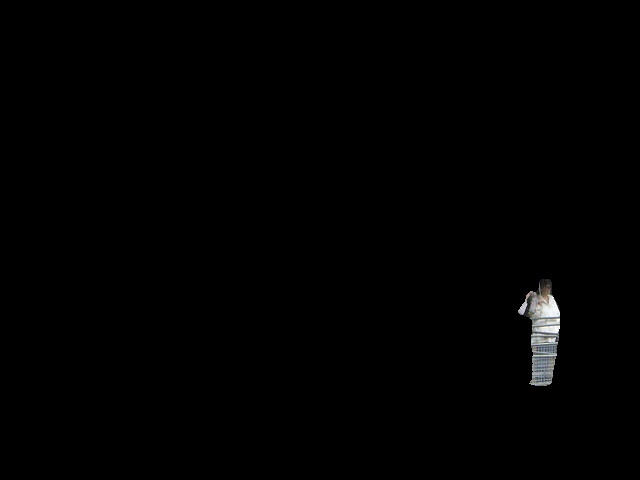

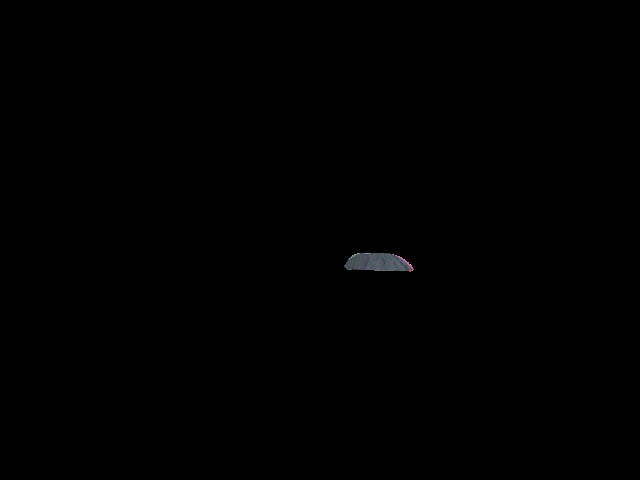

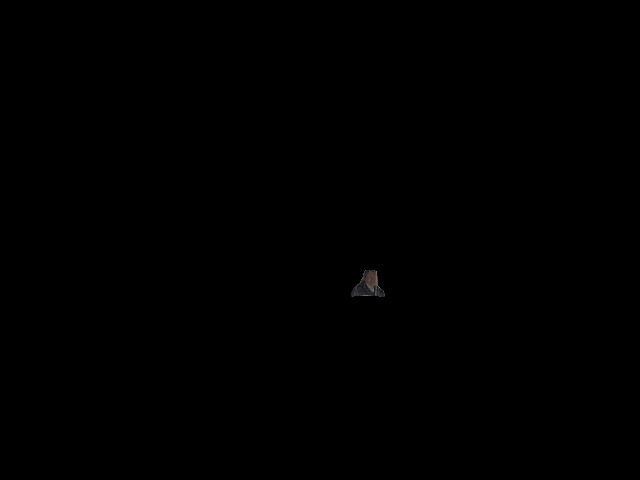

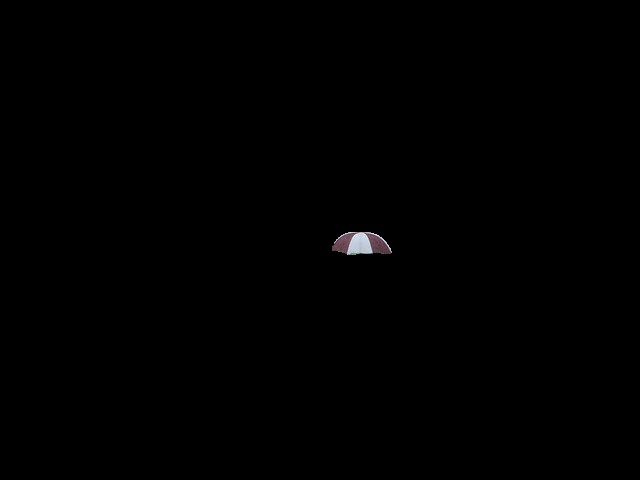

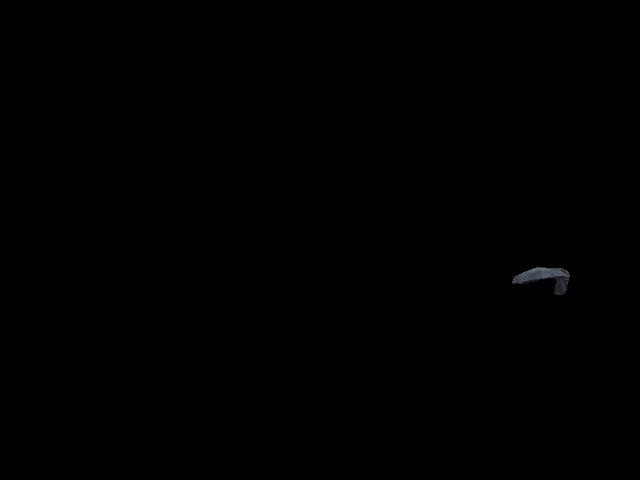

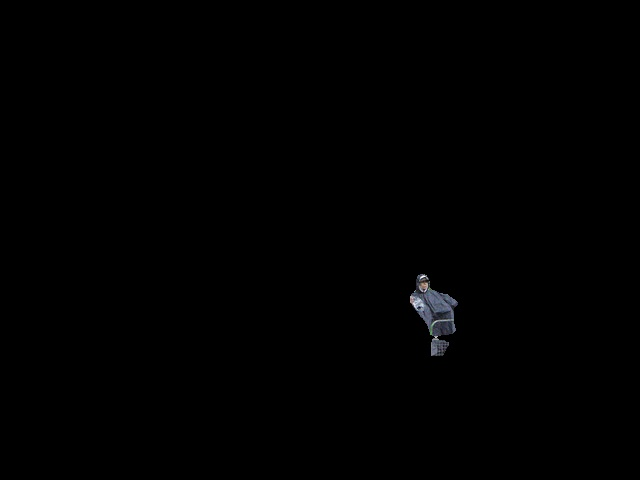

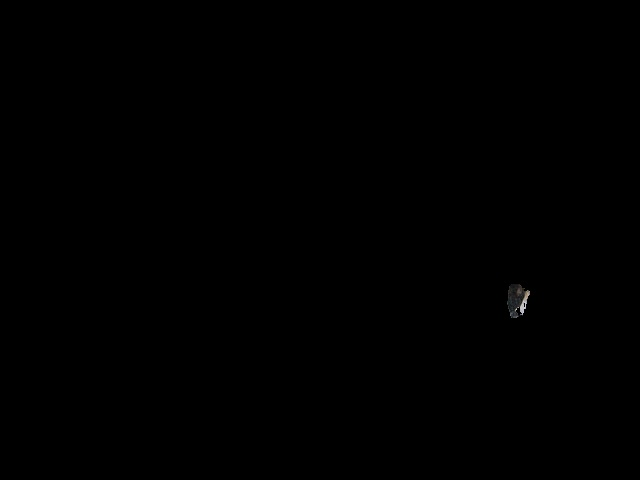

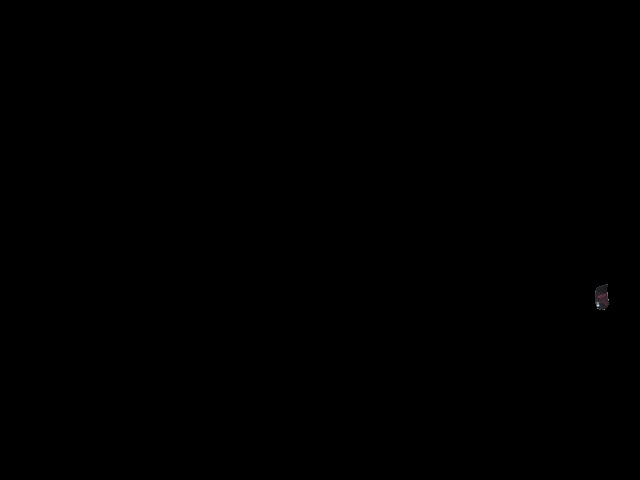

In [84]:
# Example showing how to extract all masked images

instances = outputs["instances"].to("cpu")
class_labels = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes

for i in range(len(instances)):
    instance = instances[i]
    class_label = class_labels[instance.pred_classes[0]]
    mask = instance.pred_masks[0].mul(255).byte().cpu().numpy()
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    display(ipy_Image(data=cv2.imencode('.jpg', masked_image_rgb)[1]))